# Introduction

This notebook models microbial community dynamics by combining genome-scale metabolic models (GSMMs) in SBML format with a consumer-resource framework. 

It extracts resource uptake patterns from SBML models, builds a dynamic CRM (Consumer Resource Model), simulates the system using Antimony + Basico, and visualizes species and resource trajectories.

## Function Highlights 

-  xml_dict(path): Collects SBML files into a dict {name: path}.
- species_data(models): Extracts uptake resources and traits.

- generate_crm_parameters_from_sbml(): Builds CRM param matrix (c, tau, m, etc.).

- generate_antimony_crm_multi(): Creates Antimony model using species/resource names.

- run_basico_simulation_from_antimony(): Runs dynamic simulation.

- plot_species_and_resources(): Visualizes species and resource dynamics.

In [8]:
from CRM.crm_basico_pipeline import *
from CRM.classical_crm import *
import tellurium as te

In [9]:
# Load gut normal models
gut_normal = {
    'B. caccae': '/Users/edwin/Downloads/reconstructions/GSMM/Bacteroides_caccae_ATCC_43185.xml',
    'E. rectale': '/Users/edwin/Downloads/reconstructions/GSMM/Eubacterium_rectale_ATCC_33656.xml'}

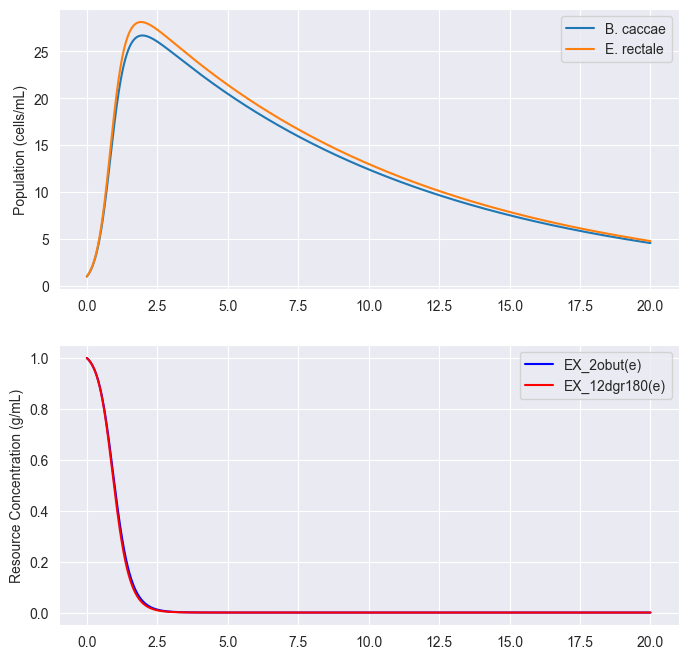

In [3]:
# take the model files, extract
a = species_data(gut_normal)
crm_basico = new_model(name='basico_crm')
new_basico = basico_model("basico_crm", a)

# run basico model and save results
t = np.linspace(0, 20, 5001)
result_default = run_time_course(model=new_basico, duration=500, values=t)

# display/plot results
plt.figure(figsize=(8, 8))

# Population Growth
plt.subplot(2, 1, 1)
plt.plot(result_default.index, result_default['B._caccae'], label='B. caccae')
plt.plot(result_default.index, result_default['E._rectale'], label='E. rectale')
plt.ylabel('Population (cells/mL)')
plt.legend()

# Resource Dynamics
plt.subplot(2, 1, 2)
plt.plot(result_default.index, result_default['EX_2obut(e)'], label='EX_2obut(e)', color='blue')
plt.plot(result_default.index, result_default['EX_12dgr180(e)'], label='EX_12dgr180(e)', color='red')
plt.ylabel('Resource Concentration (g/mL)')
plt.legend()
plt.show()

In [13]:
# Extract CRM parameters from an SBML model.
# This function likely parses the SBML model (e.g., a GSMM or a CRM-formatted SBML)
# and returns:
# - `params`: a dictionary or object containing CRM parameters (e.g., uptake rates, mortality, yield)
# - `resource_ids`: list of resource/metabolite names
# - `species_names`: list of species names
params, resource_ids, species_names = generate_crm_parameters_from_sbml(gut_normal)

# Set the initial population sizes for each species to 0.2
# This is often used as a nonzero starting point to avoid extinction from numerical zero.
initial_N = [0.2] * len(species_names)

# Set the initial concentrations of each resource to 10.0
# This assumes all resources are abundantly available at the start.
initial_R = [10.0] * len(resource_ids)

# Generate an Antimony string that encodes a consumer-resource model (CRM)
# with multiple species and resources using the specified parameters.
# The generated model includes species dynamics, resource dynamics, and interactions.
# The `resource_mode='external'` indicates a model where resources are supplied externally

ant_str = generate_antimony_crm_multi(
    species_names=species_names,
    resource_names=resource_ids,
    params=params,
    initial_N=initial_N,
    initial_R=initial_R,
    resource_mode='tilman'
)

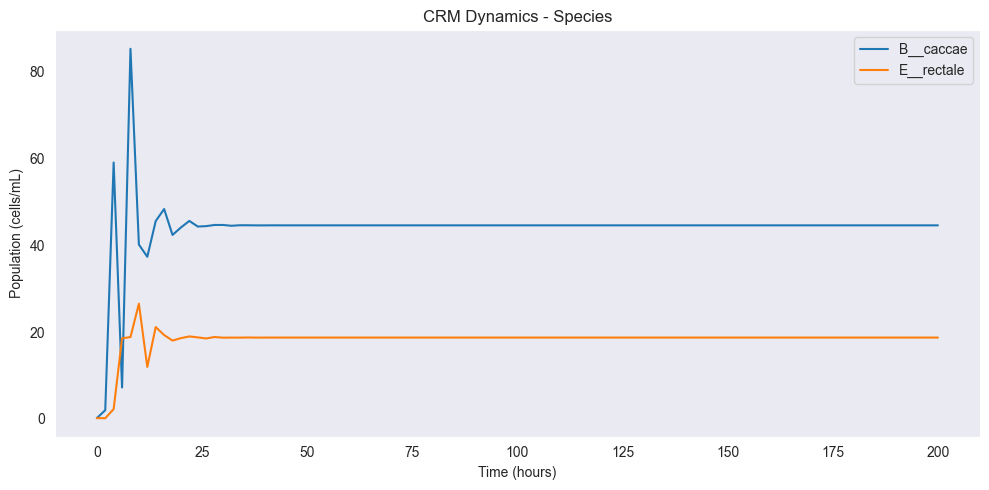

/Users/edwin/PycharmProjects/CRM/CRM/crm_basico_pipeline.py:346: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



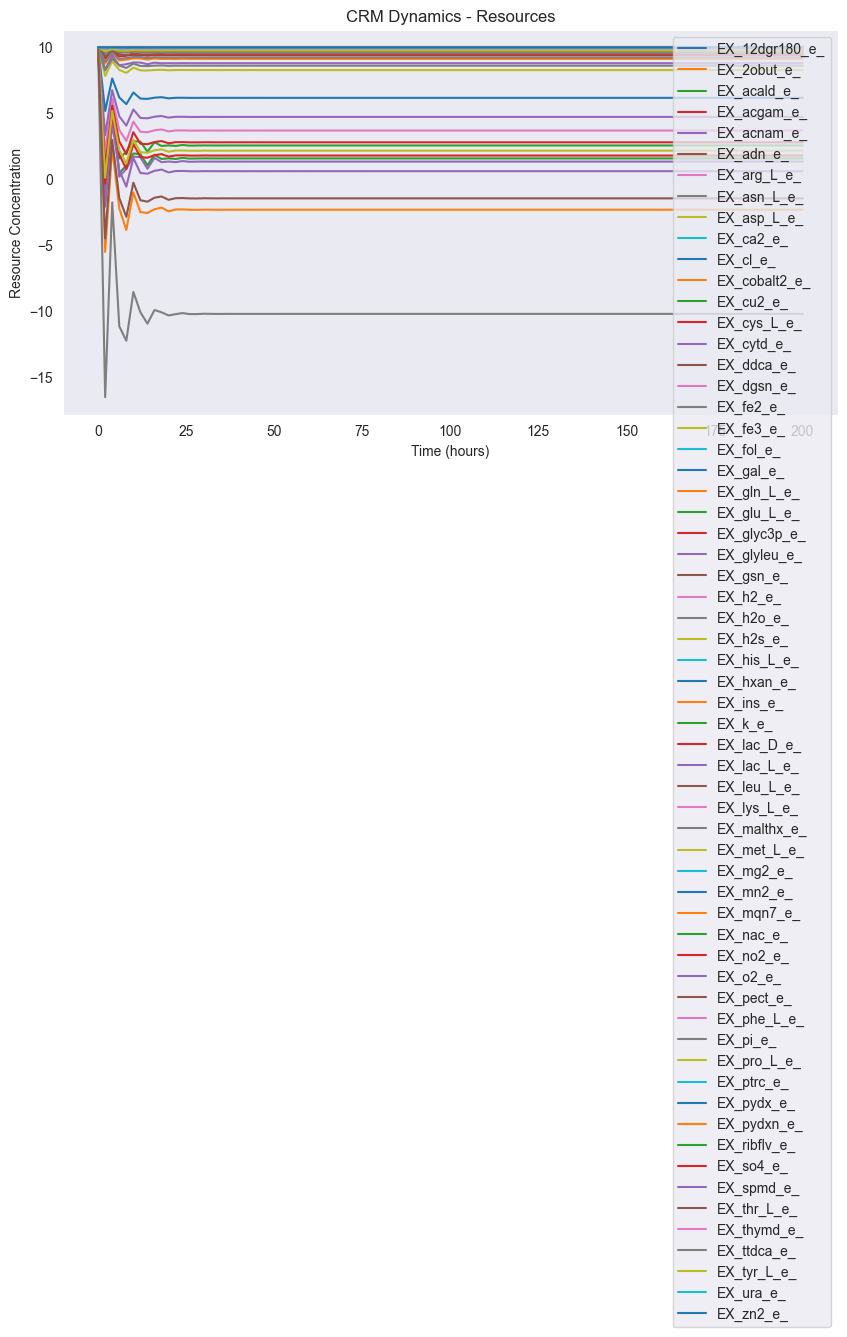

In [14]:
result_df = run_basico_simulation_from_antimony(ant_str, duration=200)

# Plot both populations and resource concentrations
plot_species_and_resources(result_df, species_names, resource_ids)

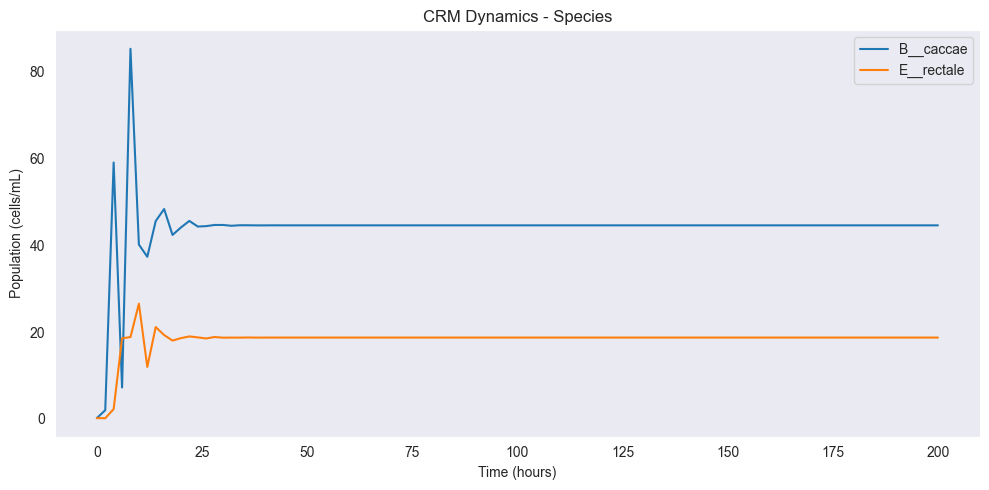

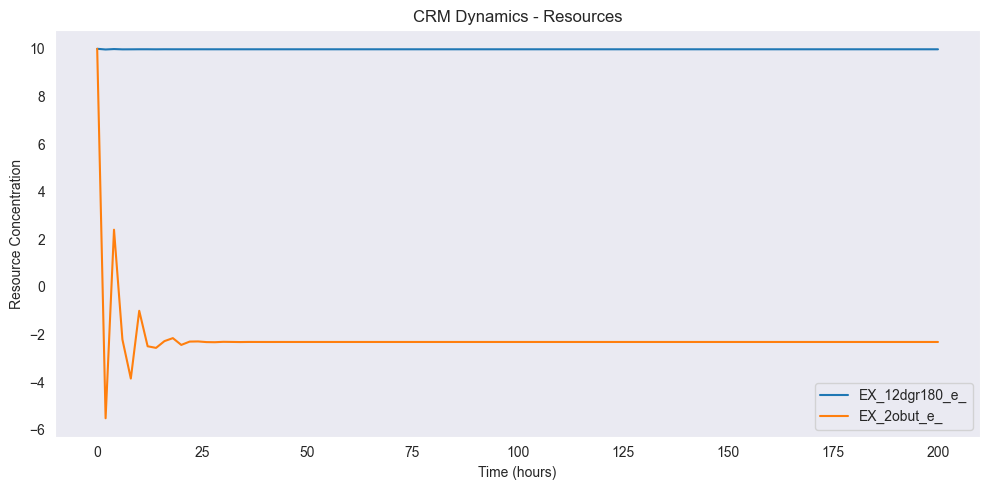

In [15]:
# Plot specific ones
plot_species_and_resources(result_df, species_names, resource_ids,
                           species_to_plot=species_names, 
                           resources_to_plot=['EX_12dgr180(e)','EX_2obut(e)'])

# Save the model in sbml format
This can be then take to copasi for further exploration.

In [16]:
save_antimony_as_sbml(ant_str, "simple_model.xml", path= "/Users/edwin/PycharmProjects/CRM/")

SBML model saved as '/Users/edwin/PycharmProjects/CRM/simple_model.xml'
